<a href="https://colab.research.google.com/github/nbrrawal/Deep_learning-/blob/main/fastai_Sample_example_pytorch_vs_FASTAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai
!pip install livelossplot 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
from fastai.vision.all import *
import torchvision
import torchvision.transforms as transforms
from livelossplot import PlotLosses

In [4]:
URLs.MNIST

'https://s3.amazonaws.com/fast-ai-imageclas/mnist_png.tgz'

In [6]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls()

(#2) [Path('testing'),Path('training')]

In [7]:
(path/"training").ls()

(#10) [Path('training/6'),Path('training/5'),Path('training/9'),Path('training/1'),Path('training/7'),Path('training/8'),Path('training/0'),Path('training/2'),Path('training/3'),Path('training/4')]

In [8]:
(path/"testing").ls()

(#10) [Path('testing/6'),Path('testing/5'),Path('testing/9'),Path('testing/1'),Path('testing/7'),Path('testing/8'),Path('testing/0'),Path('testing/2'),Path('testing/3'),Path('testing/4')]

In [10]:
image = Image.open((path/"training/3").ls()[0])
image

In [11]:
image.size

(28, 28)

In [12]:
transform = transforms.Compose(
    [transforms.Grayscale(), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
)

In [13]:
full_dataset = torchvision.datasets.ImageFolder((path/"training").as_posix(), transform = transform)

# Splitting the above dataset into a training and validation dataset
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
training_set, validation_set = torch.utils.data.random_split(full_dataset, [train_size, valid_size])

# Dataset using the "testing" folder
testing_set = torchvision.datasets.ImageFolder((path/"testing").as_posix(), transform = transform)

In [15]:
bs = 64

train_loader = torch.utils.data.DataLoader(training_set, batch_size=bs, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=bs)
dataloaders = {
    "train": train_loader,
    "validation": validation_loader
}

In [16]:
pytorch_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 50),
    nn.ReLU(),
    nn.Linear(50,10),
    nn.LogSoftmax(dim=1))

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lr = 1e-2
nb_epoch = 77

In [18]:
optimizer = torch.optim.SGD(pytorch_net.parameters(), lr=lr)

In [19]:
criterion = nn.NLLLoss()

In [20]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    liveloss = PlotLosses() # Live training plot generic API
    model = model.to(device) # Moves and/or casts the parameters and buffers to device.
    
    for epoch in range(num_epochs): # Number of passes through the entire training & validation datasets
        logs = {}
        for phase in ['train', 'validation']: # First train, then validate
            if phase == 'train':
                model.train() # Set the module in training mode
            else:
                model.eval() # Set the module in evaluation mode

            running_loss = 0.0 # keep track of loss
            running_corrects = 0 # count of carrectly classified inputs

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) # Perform Tensor device conversion
                labels = labels.to(device)

                outputs = model(inputs) # forward pass through network
                loss = criterion(outputs, labels) # Calculate loss

                if phase == 'train':
                    optimizer.zero_grad() # Set all previously calculated gradients to 0
                    loss.backward() # Calculate gradients
                    optimizer.step() # Step on the weights using those gradient w -=  gradient(w) * lr

                _, preds = torch.max(outputs, 1) # Get model's predictions
                running_loss += loss.detach() * inputs.size(0) # multiply mean loss by the number of elements
                running_corrects += torch.sum(preds == labels.data) # add number of correct predictions to total

            epoch_loss = running_loss / len(dataloaders[phase].dataset) # get the "mean" loss for the epoch
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset) # Get proportion of correct predictions
            
            # Logging
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs) # Update logs
        liveloss.send() # draw, display stuff

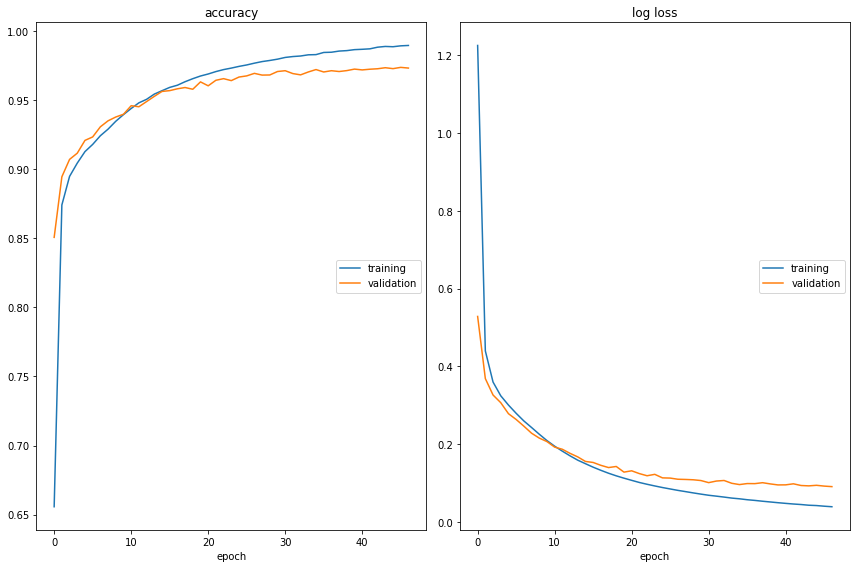

accuracy
	training         	 (min:    0.656, max:    0.990, cur:    0.990)
	validation       	 (min:    0.851, max:    0.974, cur:    0.973)
log loss
	training         	 (min:    0.039, max:    1.225, cur:    0.039)
	validation       	 (min:    0.091, max:    0.528, cur:    0.091)


KeyboardInterrupt: ignored

In [25]:
train_model(pytorch_net, criterion, optimizer, dataloaders, nb_epoch)

In [ ]:
torch.save(pytorch_net, 'models/pytorch-97.7acc.pt')

***********************************************************************


---Fast AI 


***********************************************************************

In [26]:
block = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        get_y=parent_label,
        batch_tfms=aug_transforms(mult=2., do_flip=False))

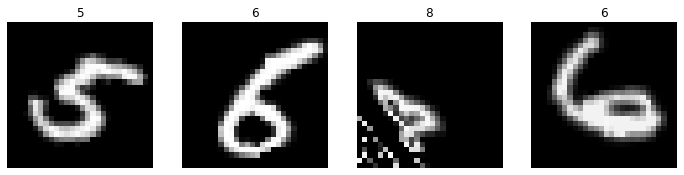

In [27]:
loaders = block.dataloaders(path/"training")
loaders.train.show_batch(max_n=4, nrows=1)

In [28]:
learn = cnn_learner(loaders, resnet34, metrics=accuracy)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627

  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0020892962347716093)

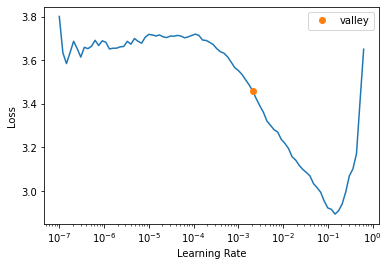

In [29]:
learn.lr_find()

In [ ]:
learn.fine_tune(12, base_lr=1e-2, cbs=[ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.export("models/fastai-99acc.pkl")

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix()

https://jonathan-sands.com/deep%20learning/fastai/pytorch/vision/classifier/2020/11/15/MNIST.html

In [ ]:
interp.plot_top_losses(10)

In [ ]:
def test_model(model, criterion, test_loader):
    model = model.to(device) # Moves and/or casts the parameters and buffers to device.
    test_loss = 0.0 # keep track of loss
    test_corrects = 0 # count of carrectly classified inputs

    with torch.no_grad(): # Disable gradient calculation
        for inputs, labels in test_loader:
            inputs = inputs.to(device) # Perform Tensor device conversion
            labels = labels.to(device)
        
            outputs = model(inputs) # forward pass through network
            loss = criterion(outputs, labels) # Calculate loss
         
            _, preds = torch.max(outputs, 1)
        
            test_loss += loss * inputs.size(0) # multiply mean loss by the number of elements
            test_corrects += torch.sum(preds == labels.data) # add number of correct predictions to total
    
        avg_loss = test_loss / len(test_loader.dataset) # get the "mean" loss for the epoch
        avg_acc = test_corrects.float() / len(test_loader.dataset) # Get proportion of correct predictions
    
    return avg_loss.item(), avg_acc.item()

PYTORCH

In [ ]:
testing_loader = torch.utils.data.DataLoader(testing_set, batch_size=bs)
 

pytorch_loss, pytorch_accuracy = test_model(pytorch_net, criterion, testing_loader)

def print_loss_acc(loss, acc):
    print("Loss : {:.6f}".format(loss))
    print("Accuracy : {:.6f}".format(acc))

print_loss_acc(pytorch_loss, pytorch_accuracy)

FAST AI 

In [ ]:
learn = load_learner('models/fastai-99acc.pkl')

test_dl = learn.dls.test_dl(get_image_files(path/"testing"), with_labels=True)
 
fastai_loss, fastai_accuracy = learn.validate(dl=test_dl)

print_loss_acc(fastai_loss, fastai_accuracy)